In [139]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
import os

In [140]:
from keras.models import Sequential, Model, load_model
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
import tensorflow as tf
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam,SGD
from keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.backend import clear_session
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet50

Make DataFrame For Data

In [141]:
import os
def make_dir_label_dataframe(path,keyword):

    class_folders = os.listdir(path)
    image_paths = []
    labels = []

    for class_folder in class_folders:
        for key in keyword:
            if key in class_folder:
                class_path = os.path.join(path, class_folder)
                image_files = os.listdir(class_path)
                for image_file in image_files:
                    image_path = os.path.join(class_path, image_file)
                    image_paths.append(image_path)
                    labels.append(class_folder)
    return  image_paths,labels
                    

In [142]:
import os
path = '/kaggle/input/brain-tumor-classification-mri/Training'
keyword=[]
for key in os.listdir(path) :
    keyword.append(key)
    print(key)
    
    

no_tumor
pituitary_tumor
meningioma_tumor
glioma_tumor


In [143]:
image,label=make_dir_label_dataframe(path,keyword)

In [144]:
import pandas as pd
df = pd.DataFrame({'image_path': image, 'label': label})
df.head(10)


,image_path,label
0,/kaggle/input/brain-tumor-classification-mri/T...,no_tumor
1,/kaggle/input/brain-tumor-classification-mri/T...,no_tumor
2,/kaggle/input/brain-tumor-classification-mri/T...,no_tumor
3,/kaggle/input/brain-tumor-classification-mri/T...,no_tumor
4,/kaggle/input/brain-tumor-classification-mri/T...,no_tumor
5,/kaggle/input/brain-tumor-classification-mri/T...,no_tumor
6,/kaggle/input/brain-tumor-classification-mri/T...,no_tumor
7,/kaggle/input/brain-tumor-classification-mri/T...,no_tumor
8,/kaggle/input/brain-tumor-classification-mri/T...,no_tumor
9,/kaggle/input/brain-tumor-classification-mri/T...,no_tumor


In [145]:
df.tail(10)

,image_path,label
2860,/kaggle/input/brain-tumor-classification-mri/T...,glioma_tumor
2861,/kaggle/input/brain-tumor-classification-mri/T...,glioma_tumor
2862,/kaggle/input/brain-tumor-classification-mri/T...,glioma_tumor
2863,/kaggle/input/brain-tumor-classification-mri/T...,glioma_tumor
2864,/kaggle/input/brain-tumor-classification-mri/T...,glioma_tumor
2865,/kaggle/input/brain-tumor-classification-mri/T...,glioma_tumor
2866,/kaggle/input/brain-tumor-classification-mri/T...,glioma_tumor
2867,/kaggle/input/brain-tumor-classification-mri/T...,glioma_tumor
2868,/kaggle/input/brain-tumor-classification-mri/T...,glioma_tumor
2869,/kaggle/input/brain-tumor-classification-mri/T...,glioma_tumor


In [146]:
print(len(df["label"]))

2870


In [147]:
classes_num=len(df["label"].unique())
classes_num

4

Visualization

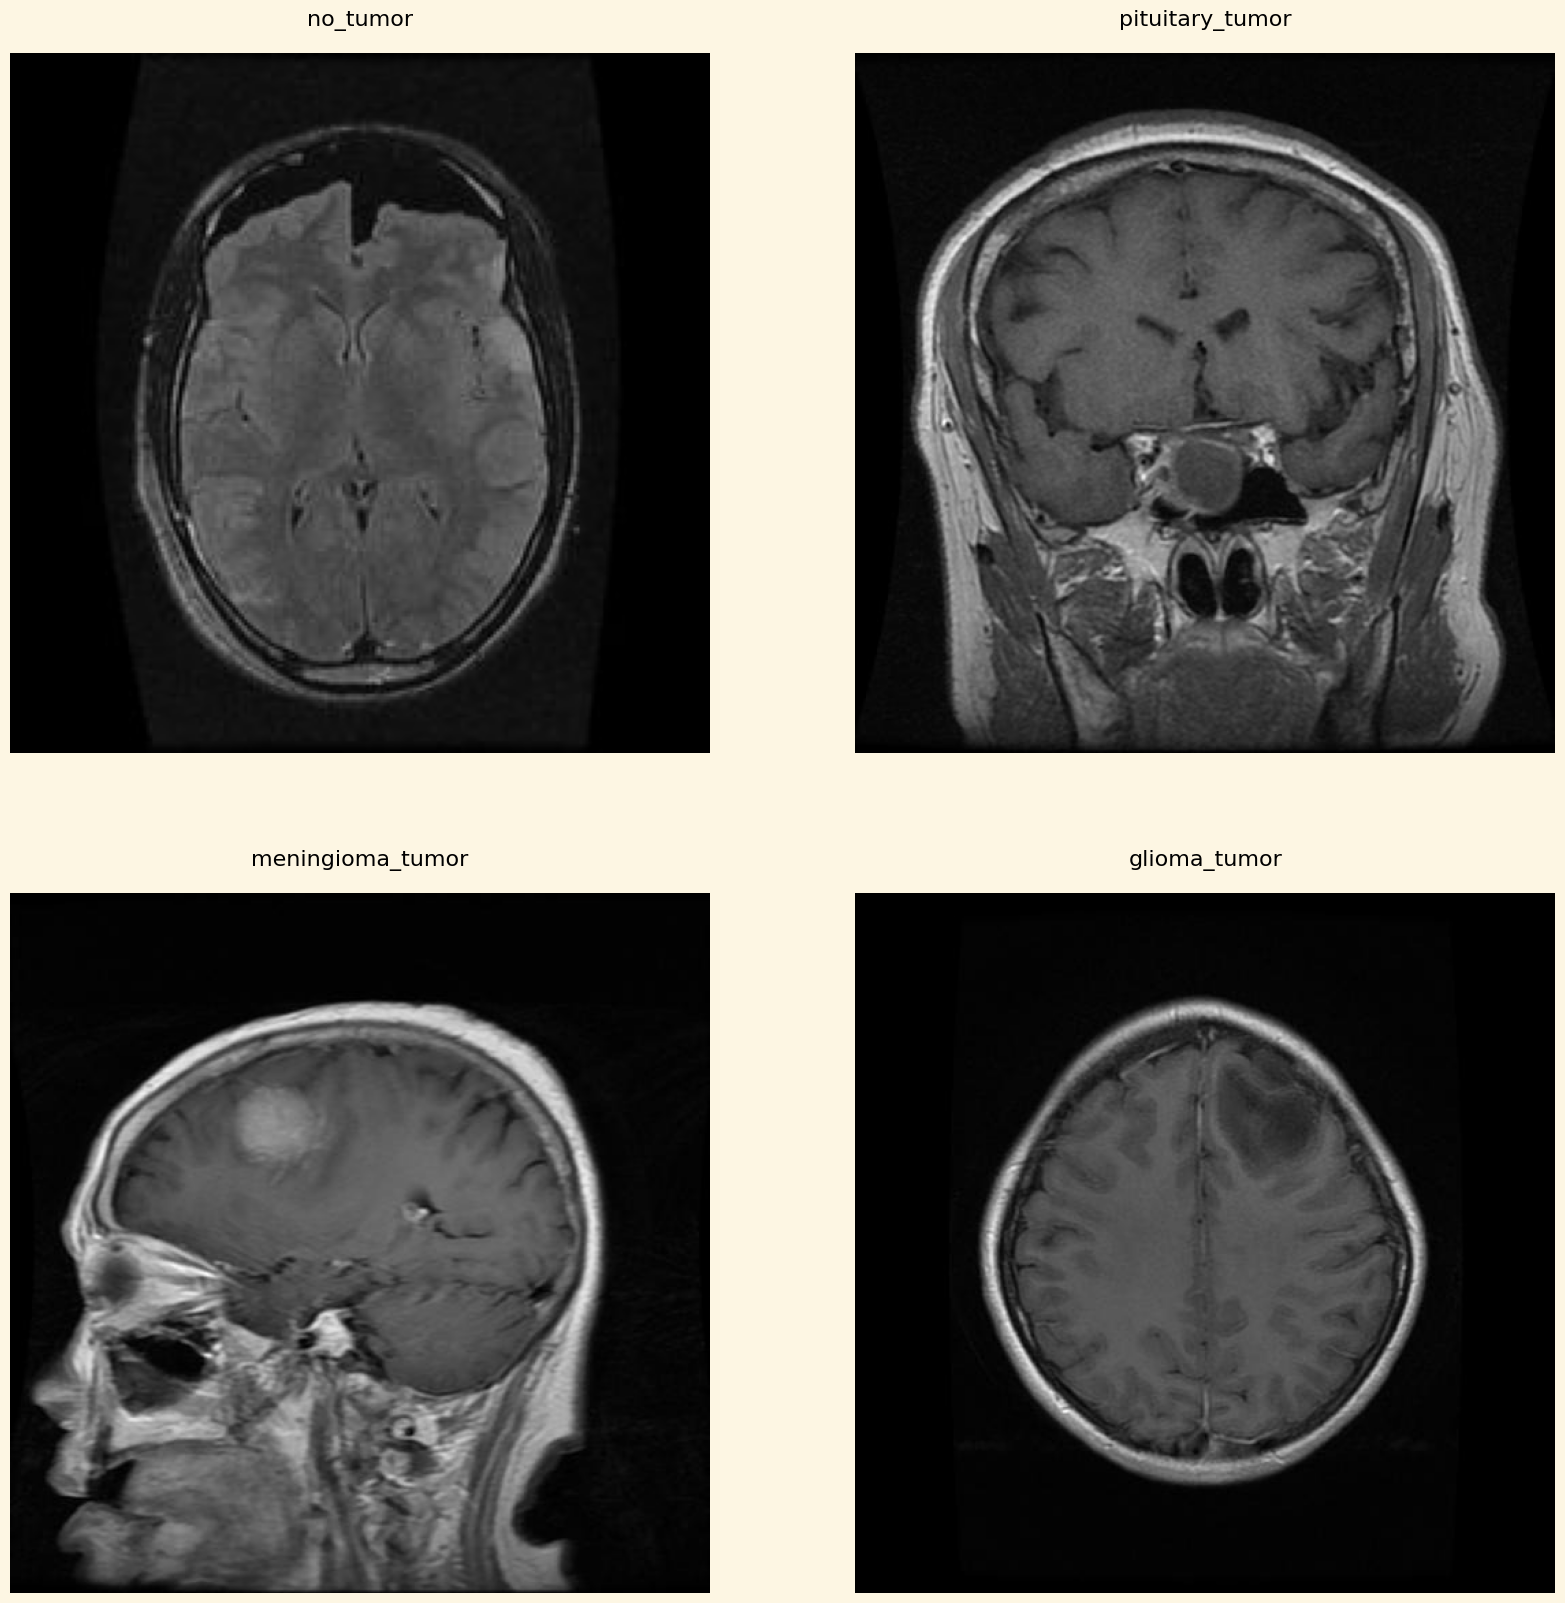

In [148]:
import cv2
import matplotlib.pyplot as plt

def Disply():
    plt.figure(figsize=(20,20))
    for i, class_name in enumerate(keyword):
        plt.subplot(2, 2, i + 1)

        img_RGB= cv2.imread(df[df['label']==class_name]['image_path'].iloc[1])
        if img_RGB is not None:
            plt.imshow(cv2.cvtColor(img_RGB, cv2.COLOR_BGR2RGB))
            plt.title(class_name)
            plt.axis('off')


plt.show()

Disply()

In [149]:
class_counts = df['label'].value_counts()
print(class_counts)

label
pituitary_tumor     827
glioma_tumor        826
meningioma_tumor    822
no_tumor            395
Name: count, dtype: int64


In [150]:
size_list=[]
for size in class_counts:
    size_list.append(size)

In [151]:
size_list

[827, 826, 822, 395]

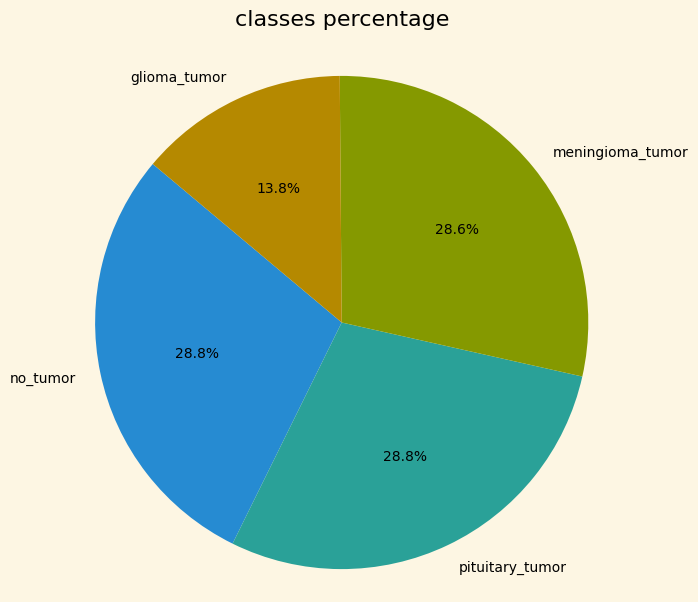

In [152]:
import matplotlib.pyplot as plt


labels = keyword
sizes = size_list

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

plt.title("classes percentage")

plt.axis('equal')
plt.show()


In [153]:
training, validation = train_test_split(df, test_size= 0.25, random_state= 42,shuffle = True)
#training, validation = train_test_split(train, test_size= 0.25, random_state= 42, shuffle = True)

In [154]:
test.shape

(1266, 2)

In [155]:
training.shape

(2152, 2)

In [156]:
test.shape[0]+training.shape[0]+validation.shape[0]==len(df)

False

In [158]:
target_size = (224, 224)

# Data Augmentation for the training data
train_datagen = ImageDataGenerator( 
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.4,1.2],
    fill_mode='nearest'
)

valid_test_datagen = ImageDataGenerator()

def create_dataset(df, is_training=False):
    if is_training:
        datagen = train_datagen
    else:
        datagen = valid_test_datagen
    return datagen.flow_from_dataframe(df, x_col='image_path', y_col='label', class_mode='categorical', shuffle=is_training, target_size=target_size)

# Creating datasets
train_dataset = create_dataset(training, is_training=True)
valid_dataset = create_dataset(validation)


Found 2152 validated image filenames belonging to 4 classes.
Found 718 validated image filenames belonging to 4 classes.


Loading Model Stracture

In [159]:


loaded_model = load_model('/kaggle/input/tumor-detection-model/Tumor_pitu_glioma_menin_model.h5')

loaded_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 432)               663984    
                                                                 
 dropout (Dropout)           (None, 432)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1732      
                                                                 
Total params: 11455395 (43.70 MB)
Trainable params: 6687

In [176]:

learning_rate = 0.001

optimizer = SGD(learning_rate=learning_rate, momentum=0.9)
loaded_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=5)

history = loaded_model.fit(train_dataset,
                    epochs = 20,
                    validation_data = valid_dataset,
                    callbacks = [early_stop])



Epoch 1/20


2024-02-25 18:24:16.705244: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


119/119 [==============================] - 107s 664ms/step - loss: 1.6532 - accuracy: 0.8588 - val_loss: 1.5038 - val_accuracy: 0.9147
Epoch 2/20
119/119 [==============================] - 79s 661ms/step - loss: 1.5748 - accuracy: 0.8878 - val_loss: 1.5299 - val_accuracy: 0.9155
Epoch 3/20
119/119 [==============================] - 79s 659ms/step - loss: 1.5399 - accuracy: 0.8978 - val_loss: 1.4936 - val_accuracy: 0.9218
Epoch 4/20
119/119 [==============================] - 78s 656ms/step - loss: 1.4916 - accuracy: 0.9007 - val_loss: 1.4423 - val_accuracy: 0.9250
Epoch 5/20
119/119 [==============================] - 79s 658ms/step - loss: 1.4664 - accuracy: 0.9044 - val_loss: 1.4439 - val_accuracy: 0.9218
Epoch 6/20
119/119 [==============================] - 79s 665ms/step - loss: 1.4114 - accuracy: 0.9223 - val_loss: 1.4039 - val_accuracy: 0.9289
Epoch 7/20
119/119 [==============================] - 80s 666ms/step - loss: 1.3845 - accuracy: 0.9297 - val_loss: 1.3843 - val_accuracy: 0.

In [190]:
loaded_model.save_weights("model.h5")

In [179]:
training_dataset = valid_test_datagen.flow_from_directory('/kaggle/input/brain-tumor-classification-mri/Testing',
                                                        target_size = (224, 224),
                                                        batch_size = 1,
                                                        class_mode = 'categorical'
                                                         )

Found 394 images belonging to 4 classes.


In [ ]:
training_dataset.classes

In [181]:
training_dataset.class_indices

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

In [184]:
pred = loaded_model.predict(test_dataset)
pred

40/40 [==============================] - 16s 343ms/step


array([[8.7295666e-05, 2.4413135e-05, 1.4323123e-07, 9.9988818e-01],
       [4.6745148e-01, 5.3254837e-01, 3.4636482e-08, 9.1240004e-08],
       [1.3685196e-05, 9.9995708e-01, 1.3584881e-06, 2.7840724e-05],
       ...,
       [2.3491610e-02, 1.0310270e-01, 8.6772567e-01, 5.6799920e-03],
       [4.1359272e-09, 3.5925698e-06, 2.2901690e-10, 9.9999642e-01],
       [5.1995987e-01, 4.7998416e-01, 5.5956039e-06, 5.0359431e-05]],
      dtype=float32)

In [185]:
pred = np.argmax(forecasts, axis = 1)
pred

array([3, 1, 1, ..., 2, 3, 0])

In [186]:
from sklearn.metrics import accuracy_score
accuracy_score(test_dataset.classes, forecasts)

0.966824644549763

In [187]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_dataset.classes, forecasts)
cm

array([[286,  19,   2,   4],
       [  8, 456,   1,   2],
       [  1,   1, 116,   2],
       [  2,   0,   0, 366]])

<Axes: >

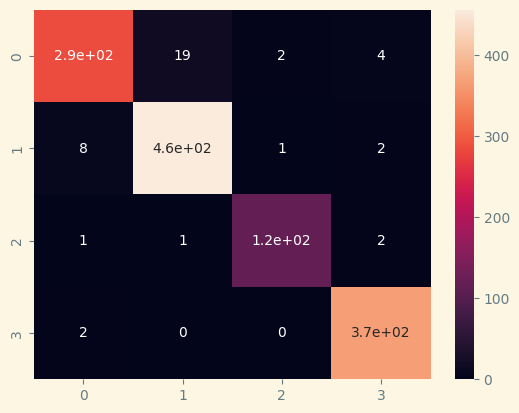

In [188]:
sns.heatmap(cm, annot=True)

In [234]:
path_image=r"/kaggle/input/brain-tumor-classification-mri/Testing/meningioma_tumor/image(15).jpg"
image=cv2.imread(path_image)

Text(0.5, 1.0, 'meningioma_tumor')

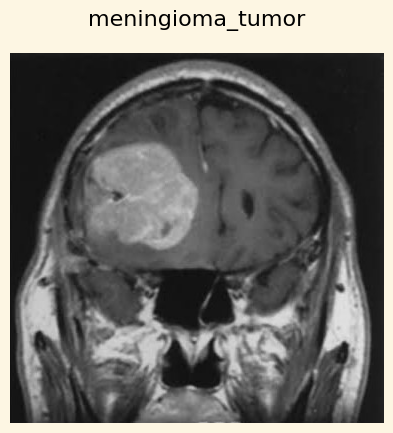

In [235]:
parts=path_image.split("/")
title=parts[-2]
plt.imshow(cv2.cvtColor(image,cv2.COLOR_RGB2BGR))
plt.axis("off")
plt.title(title)

In [250]:
import tensorflow as tf

# Load the image
image = tf.io.read_file(path_image)
image = tf.image.decode_jpeg(image, channels=3)

# Resize the image to 244x244
resized_image = tf.image.resize(image, [224, 224])

# Add a batch dimension and reshape the image to match the input shape of the model (-1, 244, 244, 3)
reshaped_image = tf.reshape(resized_image, [-1, 224, 224, 3])


In [264]:
result = loaded_model(reshaped_image)
result

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[6.4174100e-03, 9.9358022e-01, 7.2767813e-07, 1.6038115e-06]],
      dtype=float32)>

In [265]:
result = np.argmax(result)
result

1

In [257]:
test_dataset.class_indices

{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}

In [267]:
if result == 0:
    print('glioma')
elif result == 1:
    print('meningioma')
elif result == 2:
    print('no_tumor')   
else:
    print('pituitary')

meningioma
